In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment5

/home/pengyu.zhang/project/superres/ProbSR/Experiment5


In [3]:
from data_generation import *
from downscaling import *
import cv2
import torchvision.transforms as T
import torch.nn.functional as F
import time
import numpy as np
import scipy.ndimage
from scipy.ndimage import gaussian_filter

## Bicubic interpolation downscale

### Upscale by 4

In [4]:
N_low = 17
N_high = 65
scale = 4
a, b, c, d = 1,1,1,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
z_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)
z_high = np.arange(0,1.0001,h_high)

In [5]:
w_low, r_low, A_low, x_low, y_low, z_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high, z_high = generate_data(N_high,a,b,c,d)

/home/pengyu.zhang/project/superres/ProbSR/Experiment5/data_generation.py:188: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  w = linalg.spsolve(A,r).reshape((N,N,N))


In [6]:
start = time.time()
w = linalg.spsolve(A_high,r_high).reshape((N_high,N_high,N_high))
end = time.time()

print(end-start)

/tmp/ipykernel_1841725/3663376570.py:2: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  w = linalg.spsolve(A_high,r_high).reshape((N_high,N_high,N_high))


369.12828826904297


In [54]:
w_low_matrix = np.zeros((16,16,16))
for i in range(16):
    for j in range(16):
        for k in range(16):
            w_low_matrix[i][j][k] = w_high[4*i][4*j][4*k]

In [55]:
w_low_bicubic = scipy.ndimage.zoom(w_high, [16/61,16/61,16/61], order=3)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.0001
ll_sigma = 0.001

In [8]:
operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c,d)

In [9]:
# Parameters for Langevin dynamics
K = 1000
s = 0.00001

x = torch.tensor(w_low).to(torch.float32)
chains_evolution = []
# z = F.interpolate(x.reshape(1,1,N_low,N_low,N_low),(N_high,N_high,N_high),mode='trilinear').reshape(N_high,N_high,N_high)
SR = scipy.ndimage.zoom(w_low, [65/17,65/17,65/17], order=3)
z = torch.tensor(SR).to(torch.float32)
z = z.clone().detach().requires_grad_(True)

startTime = time.time()

for i in range(K):
    # Grad log-likelihood
    x_hat = F.interpolate(z.reshape(1,1,N_high,N_high,N_high),(N_low,N_low,N_low),mode='trilinear').reshape(N_low,N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**3),(x-x_hat).reshape(N_low**3,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]

    # startTime = time.time()
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high**3,1)) - b_high.reshape(N_high**3,1)
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high,N_high])

    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

    if i > K-50:
        chains_evolution.append(z.cpu().data.numpy())  
        
endTime = time.time()
print(endTime-startTime) 

37.939939975738525


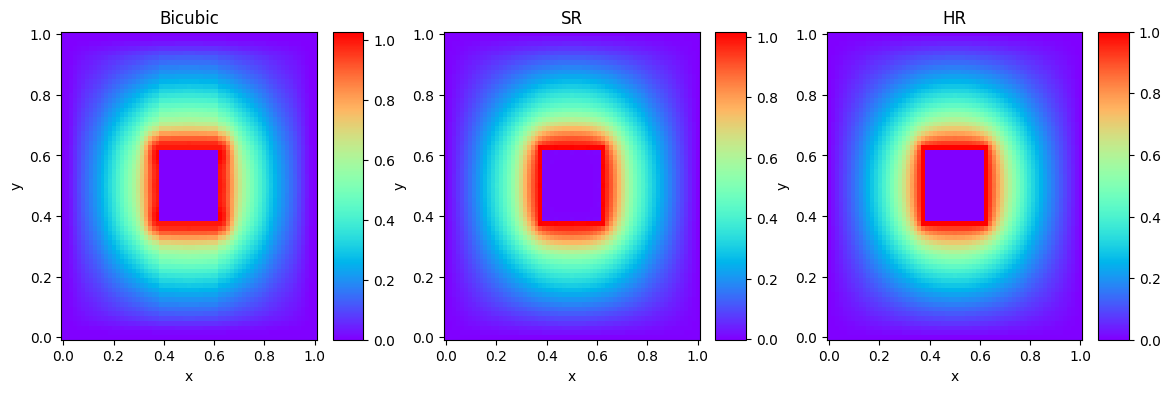

In [10]:
u_bicubic_sr = bicubic_3D(N_high,N_low,w_low)

fig = plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, u_bicubic_sr[32], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
plt.pcolormesh(x_high, y_high, z.cpu().data.numpy()[32], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high[32], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [14]:
error1 = abs(w_high - np.mean(chains_evolution,axis=0))
MSE = (error1**2).sum()/error1.shape[0]**2
print('SR L2 Error:', MSE)

SR L2 Error: 0.014058204216655759


In [15]:
10 * np.log(w_high.max()**2 / MSE)

42.645491236120854

In [16]:
error1 = abs(w_high - u_bicubic_sr)
MSE = (error1**2).sum()/error1.shape[0]**2
print('SR L2 Error:', MSE)

SR L2 Error: 0.02568561134099354


In [17]:
10 * np.log(w_high.max()**2 / MSE)

36.618243138669456